In [1]:
!pip install transformers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib import rc
import re
from collections import defaultdict

In [4]:
device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)
print(f'We are using device name "{device}"')

We are using device name "cuda"


In [5]:
# df = pd.read_csv("articles1.csv", encoding="ISO-8859-1")
df_1 = pd.read_csv("/content/drive/My Drive/ECE570/articles1.csv", encoding="ISO-8859-1")
df_2 = pd.read_csv("/content/drive/My Drive/ECE570/articles2.csv", encoding="ISO-8859-1")
df_3 = pd.read_csv("/content/drive/My Drive/ECE570/articles3.csv", encoding="ISO-8859-1")
print("FINISHED")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,6,7,8,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,25

FINISHED


In [6]:
df_1 = df_1[["id", "title", "publication", "content", "leaning"]]
df_2 = df_2[["id", "title", "publication", "content", "leaning"]]
df_3 = df_3[["id", "title", "publication", "content", "leaning"]]
df = pd.concat([df_1, df_2, df_3])

df = df[["id", "title", "publication", "content", "leaning"]]

df

,id,title,publication,content,leaning
0,17283,House Republicans Fret About Winning Their Hea...,New York Times,WASHINGTON â Congressional Republicans ha...,left
1,17284,Rift Between Officers and Residents as Killing...,New York Times,"After the bullet shells get counted, the blood...",left
2,17285,"Tyrus Wong, âBambiâ Artist Thwarted by Rac...",New York Times,When Walt Disneyâs âBambiâ opened in 194...,left
3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,"Death may be the great equalizer, but it isnâ...",left
4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,"SEOUL, South Korea â North Koreaâs lead...",left
...,...,...,...,...,...
42656,218078,An eavesdropping Uber driver saved his 16-year...,Washington Post,Uber driver Keith Avila picked up a p...,left
42657,218079,Plane carrying six people returning from a Cav...,Washington Post,Crews on Friday continued to search L...,left
42658,218080,After helping a fraction of homeowners expecte...,Washington Post,When the Obama administration announced a...,left
42659,218081,"Yes, this is real: Michigan just banned bannin...",Washington Post,This story has been updated. A new law in...,left


In [7]:
df["id"] = pd.to_numeric(df["id"], errors="coerce")
df.dropna(how="any", inplace=True)
df.dtypes
df = df[["title", "content", "leaning"]]

In [8]:
def to_leaning(leaning):
#     print(leaning)
    if leaning == "left":
        return 0
    if leaning == "center":
        return 1
    if leaning == "right":
        return 2

def text_preprocessing(s):
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    
    return s

def remove_publication(s):
  s = s.replace("- The New York Times", " ")
  s = s.replace("- Breitbart", " ")
  return s



df['title'] = df.title.apply(text_preprocessing)
df['title'] = df.title.apply(remove_publication)
df['content'] = df.content.apply(text_preprocessing)
df['leaning'] = df.leaning.apply(to_leaning)
class_names = ['left', 'center', 'right']
df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

,title,content,leaning
0,House Republicans Fret About Winning Their Hea...,WASHINGTON â Congressional Republicans ha...,0
1,Rift Between Officers and Residents as Killing...,After the bullet shells get counted the blo...,0
2,Tyrus Wong â Bambiâ Artist Thwarted by R...,When Walt Disneyâ s â Bambiâ opened in 194...,0
3,Among Deaths in 2016 a Heavy Toll in Pop Mu...,Death may be the great equalizer but it isn...,0
4,Kim Jong un Says North Korea Is Preparing to T...,SEOUL South Korea â North Koreaâ s le...,0
...,...,...,...
42656,An eavesdropping Uber driver saved his 16 year...,Uber driver Keith Avila picked up a p...,0
42657,Plane carrying six people returning from a Cav...,Crews on Friday continued to search L...,0
42658,After helping a fraction of homeowners expecte...,When the Obama administration announced a...,0
42659,Yes this is real Michigan just banned bann...,This story has been updated A new law ...,0


In [9]:
df1 = df.loc[df['leaning'] == 1]
sample_size = df1.size
sample_size = 27000

df0 = df.loc[df['leaning'] == 0]
df1 = df.loc[df['leaning'] == 1]
df2 = df.loc[df['leaning'] == 2]

df0 = df0.sample(int(sample_size))
df1 = df1.sample(int(sample_size))
df2 = df2.sample(int(sample_size))

dataframes = [df0, df1, df2]

df = pd.concat(dataframes)
df

,title,content,leaning
12596,Can We Get a Read Out ?,So how much has Nigel Farage been in DC since ...,0
32386,Have liberals found their combative new leader...,â If youâ re going to travel with me ...,0
6555,Donald Trumpâ s Jet a Regular on the Campa...,Over the past several months Donald J Tr...,0
4080,Donald Trump Embraces Wider Use of Stop and Fr...,Donald J Trump on Wednesday called for the ...,0
5933,Review The Smithsonian African American Museu...,WASHINGTON â On a late summer day in 1963...,0
...,...,...,...
7308,NRA chief challenges Obama to debate on guns,The head of the National Rifle Association bl...,2
37673,Elevator hero wished woman â Happy New Yearâ ...,â A man â wished â Happy New Yearâ to ...,2
24781,Brussels Shows the High Cost of Obamaâ s Slow...,In 2014 Barack Obama decided to respond to ...,2
26353,Hillaryâ s Disastrous Economic Plan,Hillary Rodham Clinton gave a speech on econom...,2


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


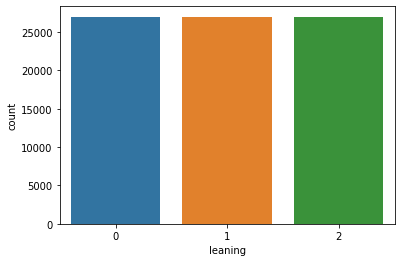

In [10]:
ax = sns.countplot(df.leaning)

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', truncation='longest_first')

In [12]:
MAX_LEN_TITLE = 40
MAX_LEN_CONTENT = 600

class GPReviewDataset(Dataset):
    
  def __init__(self, titles, targets, contents, tokenizer, max_len_title, max_len_content):
    self.titles = titles
    self.targets = targets
    self.contents = contents
    self.tokenizer = tokenizer
    self.max_len_title = max_len_title
    self.max_len_content = max_len_content
    
  def __len__(self):
    return len(self.titles)

  def __getitem__(self, item):
    title = str(self.titles[item])
    content = str(self.contents[item])
    target = self.targets[item]
    
    encoding = self.tokenizer.encode_plus(
      title,
      add_special_tokens=True,
      max_length=self.max_len_title,
      return_token_type_ids=False,
#       pad_to_max_length=True,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation='longest_first',
    )
    
    return {
      'title_text': title,
      'content_text': content,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [13]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

df_train, df_test = train_test_split(
  df,
  test_size=0.1,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

df_train.shape, df_val.shape, df_test.shape

((72900, 3), (4050, 3), (4050, 3))

In [14]:
def create_data_loader(df, tokenizer, max_len_title, max_len_content, batch_size):
  ds = GPReviewDataset(
    titles=df.title.to_numpy(),
    contents=df.content.to_numpy(),
    targets=df.leaning.to_numpy(),
    tokenizer=tokenizer,
    max_len_title=max_len_title,
    max_len_content=max_len_content
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN_TITLE, MAX_LEN_CONTENT, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN_TITLE, MAX_LEN_CONTENT, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN_TITLE, MAX_LEN_CONTENT, BATCH_SIZE)

In [15]:
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class SentimentClassifier(nn.Module):
    
  def __init__(self, n_classes):
    
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-cased')

    self.conv1 = nn.Conv2d(1, 6, 3)
    self.conv2 = nn.Conv2d(6, 24, 3)
    self.conv3 = nn.Conv2d(24, 32, 3)
    self.pool = nn.MaxPool2d(2, 2)

    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(64, n_classes)
    
  def forward(self, input_ids, attention_mask):
    
    # pooled_output is [4, 768]
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    # print(pooled_output.size)

    # [4, 1, 768]
    x = pooled_output.unsqueeze(1)
    shape = x.shape
    x = x.view(shape[0], 1, 32, int(x.shape[2]/32))

    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    # print(x.shape)
    # x = x.view(-1, 32)

    x = x.view(-1, 64)

    output = self.drop(x)
    
    return self.out(output)

model = SentimentClassifier(len(class_names))
model = model.to(device)
# input_ids = data['input_ids'].to(device)
# attention_mask = data['attention_mask'].to(device)

# print(input_ids.shape) # batch size x seq length
# print(attention_mask.shape) # batch size x seq length

In [16]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [17]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):

  model = model.train()
  losses = []
  correct_predictions = 0

  for d in data_loader:
        
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
    
  return correct_predictions.double() / n_examples, np.mean(losses)

In [18]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0

  with torch.no_grad():
        
    for d in data_loader:
        
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
    
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
        
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
        
  return correct_predictions.double() / n_examples, np.mean(losses)

In [19]:
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
    
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------
Train loss 0.6258269590909136 accuracy 0.7683539094650206
Val   loss 0.46209133651078216 accuracy 0.822716049382716

Epoch 2/5
----------
Train loss 0.4084283380699911 accuracy 0.8518518518518519
Val   loss 0.43710246840565226 accuracy 0.8360493827160494

Epoch 3/5
----------
Train loss 0.30481230988256536 accuracy 0.9012071330589849
Val   loss 0.5187203026208 accuracy 0.8365432098765432

Epoch 4/5
----------
Train loss 0.23655195603306967 accuracy 0.933840877914952
Val   loss 0.6185898783279392 accuracy 0.8414814814814815

Epoch 5/5
----------
Train loss 0.19290349140047164 accuracy 0.952071330589849
Val   loss 0.6538643247235244 accuracy 0.84



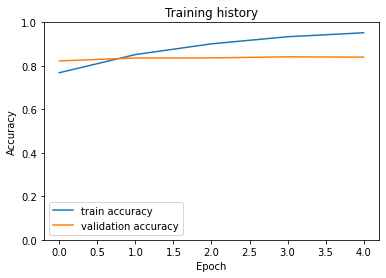

In [20]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [21]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

0.8417283950617284

In [22]:
def get_predictions(model, data_loader):
  model = model.eval()
  title_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
        
    for d in data_loader:
        
      texts = d["title_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
        
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
    
      _, preds = torch.max(outputs, dim=1)
      title_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
        
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()

  return title_texts, predictions, prediction_probs, real_values

In [23]:
y_title_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

        left       0.79      0.78      0.79      1335
      center       0.82      0.88      0.85      1365
       right       0.92      0.87      0.89      1350

    accuracy                           0.84      4050
   macro avg       0.84      0.84      0.84      4050
weighted avg       0.84      0.84      0.84      4050



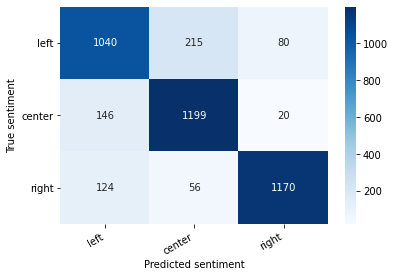

In [24]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)